<ins>Logical Workflow PA Project</ins>

0. Call Data from SQL Server and save to local .pkl. Filter by TBM 1 and time span ('2022/02/01', '2022/04/01')
1. Join data for a complete dataset
2. Initial drop duplicates, Filter (by Equipment ID: TBM 1 and remove Trial Recipes), key generation, cycle time generation and EDA
3. Left Merge Alarm mapping and Alarm hisroy on Created Key.
4. Alarm Discovery: Alarm to GT allocation: Calculate PAAP start and finish times if needed. Do NOT Filter alarms by Type e.g.  FF, CF and MC, assin name in#dexes. Link these alarm name indexes that are occurring for the same green tire at those times identified as PA. Create GT to Alarm Index Mapping.
5. One Hot encode Alarm Indexes before we carry out feature selction to see relevant alarms.
6. Feature selection: Initial Filter using statistical univariate filter methods. 
7. Feature selection: Narrow down using ML Models. Identify which steps are posing the issue (i.e. is it sidewall, inner liner, is it transport time etc.)
8. View Selected Alarms and Discuss with Operations Team
9. With an Alarm, classifed the GT's which had this alarm (allocated on entire start/produced time instead). We then join the alarm mapping with alarm history and join this table to the GT's in production data and perform counts and validate apparent erroneous durations. Sort the alarms into 'Errors' and 'Valid'. i.e. Alarm Duration < PAAP & Cycle Time is a Valid Scenario. Errors are EITHER Alarm Duration > PAAP OR Alarm Duration > PAAP & Cycle Time
    Have decided to take the subset of Duration < Cycle Time as GT's that make feasible sense.
10. Carry out More detailed analysis to gauge size of the prize. Here we have taken the 95th percentile of cycle times to remove outlier GT's. We had already previously removed Trial Recipes. Then:
    •	Analyse if they have taken each alarm once or twice. Need to sort by Null i.e. (Mahesh is handling)
    •	Count of 'Valid' Alarms. Calculate percentage out of all GT's Produced 
    •	Recalculate time saving per cycle time for start_time and ProducedOn Time. i.e. Redo Allocation of GT's
    •	See Date dependence of PA alarms. (one day may be particularly bad due to converyor belt issue, or Recipe   inherent etc.) (Automation Conveyor may have an issue on one particylar day). See if Date Dependent
11. Continuation of 10, to carry out more detailed analysis to gauge size of the prize
    •	See correlation coeff with Duration and Cycle time/PAAP time
    •	General Analysis of PAAP Times
    •	Check next and previous tyres for the Errors.   
    •	Investigate for other TBM's
12.	Plot these comparisons and highlight your observations. Add any other analysis as we go along: 
    •	Total CT variation - m/c wise
    •	CT variation - application wise
    •	Total CT variation - Diameter wise
    •	Total CT variation - Recipe wise
    •	Number of changeovers - m/c wise 
    •	Number of changeovers - due to recipe, due to diameter
13. PREASSEMBLY LENGTH NOT CORRECT Alarm investigation. Alarm Duration Distribution, as this alarms Duration IS linked to Machine Stoppage Time. GT allocation, and Alarm duration vs PAAP time check. All seems okay, as vast majority are Scenario 1.
    • Scenario 1 : Alarm Duration < PAAP Times
    • Scenario 2 : Alarm Duration > PAAP Times 
    • Scenario 3 : Alarm Duration > PAAP Times & Cycle Time

In [1]:
import pandas as pd
from helpers import TBM, bcolors, Feature_Selection, Data_Functions

DF = Data_Functions()
TBM = TBM()
p = bcolors()
FS = Feature_Selection()

In [2]:
alarm_join = pd.read_pickle("./pkl/alarms_join.pkl")
df_tbm = pd.read_pickle("./pkl/df_tbm_PAAP_times.pkl")

In [3]:
p.printg(f'Unfiltered Alarm start date: {p.ENDC} {alarm_join.TimeStamp.min()}{p.GREEN}  End Date: {p.ENDC} {alarm_join.TimeStamp.max()}')
p.printg(f'length Alarm: {p.ENDC} {len(alarm_join)}')

Unfiltered Alarm start date:  2022-02-01 00:00:30.6302739  End Date:  2022-05-15 23:59:57.2704392
length Alarm:  1002892


In [6]:
alarm_join_PA = alarm_join[alarm_join.Name.isin(['PREASSEMBLY LENGTH NOT CORRECT'])]
# 'PREASSEMBLY LENGTH NOT CORRECT'
p.printg(f'Number of PREASSEMBLY LENGTH NOT CORRECT Alarms from {alarm_join_PA.TimeStamp.min()} to {alarm_join_PA.TimeStamp.max()} : {p.ENDC} {len(alarm_join_PA)}')
alarm_join_PA.head()

Number of PREASSEMBLY LENGTH NOT CORRECT Alarms from 2022-02-01 08:46:22.3926162 to 2022-05-15 20:46:08.7053177 :  2441


,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index
770274,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20838819,2022-02-02 11:05:25.6167384,68,TBM 1,692
770275,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835338,2022-02-02 06:16:12.1957320,150,TBM 1,692
770276,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835449,2022-02-02 06:23:11.2531594,38,TBM 1,692
770277,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835503,2022-02-02 06:25:49.7315276,23,TBM 1,692
770278,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835513,2022-02-02 06:27:23.6423236,35,TBM 1,692


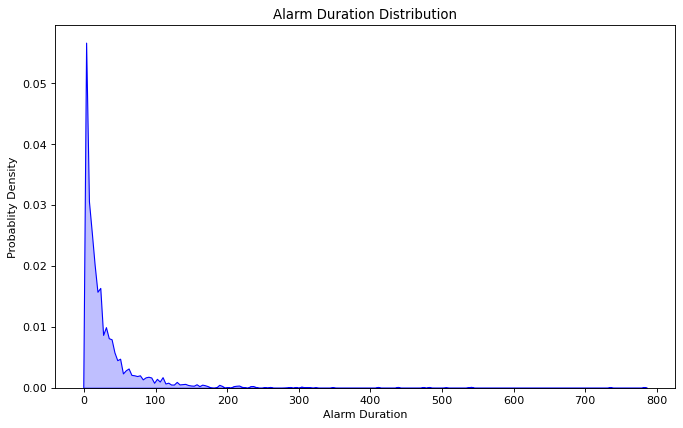

In [7]:
DF.KDE_dist_plotter(alarm_join_PA.Duration, smoothness=.1, title='Alarm Duration Distribution', xlabel='Alarm Duration')

In [8]:
p.printg(f'TBM start date: {p.ENDC} {df_tbm.ProducedOn.min()}{p.GREEN}  End Date: {p.ENDC} {df_tbm.ProducedOn.max()}')
p.printg(f'length TBM: {p.ENDC} {len(df_tbm)}')

p.printg(f'PREASSEMBLY LENGTH NOT CORRECT Alarm start date: {p.ENDC} {alarm_join_PA.TimeStamp.min()}{p.GREEN}  End Date: {p.ENDC} {alarm_join_PA.TimeStamp.max()}')
p.printg(f'length PREASSEMBLY LENGTH NOT CORRECT Alarm: {p.ENDC} {len(alarm_join_PA)}')

TBM start date:  2022-02-01 06:03:43  End Date:  2022-05-16 05:58:30
length TBM:  110584
PREASSEMBLY LENGTH NOT CORRECT Alarm start date:  2022-02-01 08:46:22.3926162  End Date:  2022-05-15 20:46:08.7053177
length PREASSEMBLY LENGTH NOT CORRECT Alarm:  2441


In [9]:
df_tbm.head(1)

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time
0,2022-02-01 06:03:43,TBM 1,1347468,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:03:43,0015600676,GG224517HYPXY,...,5.498,0.0,2.48,11141585,2022-02-01 06:02:06,97,219.620006,85.318002,2022-02-01 06:02:17.681997776,2022-02-01 06:02:12.754997730


In [10]:
alarm_join_PA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2441 entries, 770274 to 773177
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   key               2441 non-null   object
 1   Name              2441 non-null   object
 2   Type              2441 non-null   object
 3   MessageID_x       2441 non-null   int64 
 4   HistoryMessageID  2441 non-null   int64 
 5   TimeStamp         2441 non-null   object
 6   Duration          2441 non-null   int64 
 7   EquipmentID       2441 non-null   object
 8   name_index        2441 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 190.7+ KB


In [11]:
df_tbm['start_time'] = pd.to_datetime(df_tbm['start_time'])
df_tbm['ProducedOn'] = pd.to_datetime(df_tbm['ProducedOn'])
alarm_join_PA['TimeStamp'] = pd.to_datetime(alarm_join_PA['TimeStamp'])

In [12]:
alarm_join_PA.insert(0, 'ID', range(1, 1 + len(alarm_join_PA)))

In [13]:
alarm_join_PA.head()

,ID,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index
770274,1,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20838819,2022-02-02 11:05:25.616738400,68,TBM 1,692
770275,2,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835338,2022-02-02 06:16:12.195732000,150,TBM 1,692
770276,3,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835449,2022-02-02 06:23:11.253159400,38,TBM 1,692
770277,4,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835503,2022-02-02 06:25:49.731527600,23,TBM 1,692
770278,5,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835513,2022-02-02 06:27:23.642323600,35,TBM 1,692


In [14]:
df_allocated_PA = TBM.allocator(df_alarms=alarm_join_PA, df_cycle=df_tbm, df_cycle_end='ProducedOn', df_cycle_start='start_time', column_to_add_to_list='ID')

In [15]:
df_allocated_PA

,Id,list_of_alarms
0,11141585,[]
1,11141586,[]
2,11141588,[]
3,11141590,[]
4,11141591,[]
...,...,...
110579,12467918,[]
110580,12467919,[]
110581,12467920,[]
110582,12468000,[]


In [16]:
masked = FS.mask_empty_lists(df_allocated_PA)

In [17]:
masked_1 = FS.mask_empty_lists_num(masked, 1)
masked_mult = FS.mask_empty_lists_morethan(masked)

In [21]:
masked_mult['number of alarms'] = masked_mult.list_of_alarms.apply(lambda x: len(x))
masked_mult

,Id,list_of_alarms,number of alarms
4471,11187160,"[909, 910]",2
36685,11571969,"[274, 280]",2
57514,11822913,"[18, 19]",2
58310,11832321,"[1354, 1355]",2
63913,11895571,"[63, 259, 283, 1185]",4
73459,12020021,"[1573, 1972]",2
76793,12063136,"[2028, 2035]",2
88304,12209017,"[2290, 2292, 2293, 2341, 2342, 2343, 2371, 237...",18
89559,12222722,"[2295, 2296, 2297]",3
95638,12288469,"[1686, 1687]",2


In [22]:
masked_1

,Id,list_of_alarms
104,11143064,[1013]
106,11143066,[1014]
123,11143314,[1041]
130,11143415,[1036]
133,11143456,[1037]
...,...,...
109518,12456314,[1558]
109696,12458948,[1586]
109887,12460528,[1559]
110059,12463096,[1555]


In [23]:
masked_4 = FS.mask_empty_lists_num(masked, 4)
masked_4

,Id,list_of_alarms
63913,11895571,"[63, 259, 283, 1185]"


In [24]:
masked_2 = FS.mask_empty_lists_num(masked, 2)
masked_2

,Id,list_of_alarms
4471,11187160,"[909, 910]"
36685,11571969,"[274, 280]"
57514,11822913,"[18, 19]"
58310,11832321,"[1354, 1355]"
73459,12020021,"[1573, 1972]"
76793,12063136,"[2028, 2035]"
95638,12288469,"[1686, 1687]"


In [25]:
df_tbm[df_tbm.Id == 12307559][['ProducedOn', 'RecipeName', 'start_time', 'cycle_time_s', 'PAAP_Finish_time',  'PAAP_Start_time' ]]

,ProducedOn,RecipeName,start_time,cycle_time_s,PAAP_Finish_time,PAAP_Start_time
97236,2022-05-04 16:41:41,GG225017USAXY,2022-05-04 11:12:50,19731,2022-05-04 16:37:16.130005956,2022-05-04 16:35:17.093003393


In [26]:
p.printg(f'GT\'s with 1 Allocated Alarms that occur during a GT production: {p.ENDC} {len(masked_1)}')
p.printg(f'GT\'s with more than 1 Allocated Alarms that occur during a GT production: {p.ENDC} {len(masked_mult)}')

GT's with 1 Allocated Alarms that occur during a GT production:  2354
GT's with more than 1 Allocated Alarms that occur during a GT production:  11


In [27]:
PA_alarmed_gts = df_tbm[df_tbm.Id.isin(masked_1.Id.to_list())]

In [28]:
PA_alarmed_gts.head()

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time
104,2022-02-01 08:46:58,TBM 1,1347572,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 08:46:58,0015600790,GG236017HTRNH,...,5.431,0.0,3.125,11143064,2022-02-01 08:46:08,50,89.573999,36.113000,2022-02-01 08:46:21.887000203,2022-02-01 08:46:13.317000508
106,2022-02-01 08:48:51,TBM 1,1347574,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 08:48:51,0015600792,GG236017HTRNH,...,5.507,0.0,3.178,11143066,2022-02-01 08:47:43,68,95.346001,37.299000,2022-02-01 08:48:13.700999618,2022-02-01 08:48:00.626999259
123,2022-02-01 09:05:25,TBM 1,1347591,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 09:05:25,0015600809,GG236017HTRNH,...,5.414,0.0,3.180,11143314,2022-02-01 09:04:21,64,201.085001,52.122999,2022-02-01 09:04:32.877000809,2022-02-01 09:04:25.933001042
130,2022-02-01 09:21:43,TBM 1,1347598,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 09:21:43,0015600821,GG236017HTRNH,...,5.429,0.0,3.136,11143415,2022-02-01 09:18:46,177,184.883999,35.964999,2022-02-01 09:21:07.035000682,2022-02-01 09:19:24.438000560
133,2022-02-01 09:25:24,TBM 1,1347601,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 09:25:24,0015600824,GG236017HTRNH,...,5.437,0.0,3.135,11143456,2022-02-01 09:24:02,82,123.295000,36.285000,2022-02-01 09:24:47.714999557,2022-02-01 09:24:41.655999542


In [29]:
masked_1['Alarm_gen_ID'] = [','.join(map(str, l)) for l in masked_1['list_of_alarms']]

In [30]:
masked_1.head()

,Id,list_of_alarms,Alarm_gen_ID
104,11143064,[1013],1013
106,11143066,[1014],1014
123,11143314,[1041],1041
130,11143415,[1036],1036
133,11143456,[1037],1037


In [31]:
key_added = pd.merge(PA_alarmed_gts, masked_1, on='Id')

In [32]:
key_added.head()

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time,list_of_alarms,Alarm_gen_ID
0,2022-02-01 08:46:58,TBM 1,1347572,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 08:46:58,0015600790,GG236017HTRNH,...,3.125,11143064,2022-02-01 08:46:08,50,89.573999,36.113000,2022-02-01 08:46:21.887000203,2022-02-01 08:46:13.317000508,[1013],1013
1,2022-02-01 08:48:51,TBM 1,1347574,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 08:48:51,0015600792,GG236017HTRNH,...,3.178,11143066,2022-02-01 08:47:43,68,95.346001,37.299000,2022-02-01 08:48:13.700999618,2022-02-01 08:48:00.626999259,[1014],1014
2,2022-02-01 09:05:25,TBM 1,1347591,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 09:05:25,0015600809,GG236017HTRNH,...,3.180,11143314,2022-02-01 09:04:21,64,201.085001,52.122999,2022-02-01 09:04:32.877000809,2022-02-01 09:04:25.933001042,[1041],1041
3,2022-02-01 09:21:43,TBM 1,1347598,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 09:21:43,0015600821,GG236017HTRNH,...,3.136,11143415,2022-02-01 09:18:46,177,184.883999,35.964999,2022-02-01 09:21:07.035000682,2022-02-01 09:19:24.438000560,[1036],1036
4,2022-02-01 09:25:24,TBM 1,1347601,Operator,Operator 065,GG236017HTRNH,T2206002H400,20220201 09:25:24,0015600824,GG236017HTRNH,...,3.135,11143456,2022-02-01 09:24:02,82,123.295000,36.285000,2022-02-01 09:24:47.714999557,2022-02-01 09:24:41.655999542,[1037],1037


In [33]:
alarm_join_PA.rename(columns={"ID": "Alarm_gen_ID"}, inplace=True)
alarm_join_PA.head()

,Alarm_gen_ID,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index
770274,1,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20838819,2022-02-02 11:05:25.616738400,68,TBM 1,692
770275,2,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835338,2022-02-02 06:16:12.195732000,150,TBM 1,692
770276,3,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835449,2022-02-02 06:23:11.253159400,38,TBM 1,692
770277,4,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835503,2022-02-02 06:25:49.731527600,23,TBM 1,692
770278,5,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835513,2022-02-02 06:27:23.642323600,35,TBM 1,692


In [34]:
masked_4

,Id,list_of_alarms
63913,11895571,"[63, 259, 283, 1185]"


In [35]:
df_tbm[df_tbm.Id == 11248501][['ProducedOn', 'RecipeName', 'start_time', 'cycle_time_s', 'PAAP_Finish_time',  'PAAP_Start_time' ]]

,ProducedOn,RecipeName,start_time,cycle_time_s,PAAP_Finish_time,PAAP_Start_time
9272,2022-02-10 07:18:55,GG224517ULAXY,2022-02-10 07:09:38,557,2022-02-10 07:18:14.890999198,2022-02-10 07:17:46.247000098


In [36]:
alarm_join_PA[alarm_join_PA.Alarm_gen_ID.isin([1585, 1586, 1587, 1588])]

,Alarm_gen_ID,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index
772140,1585,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,22807984,2022-05-14 21:25:11.272939900,18,TBM 1,692
772141,1586,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,22818036,2022-05-15 09:58:24.580246200,35,TBM 1,692
772142,1587,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,22784131,2022-05-13 15:27:21.619941600,9,TBM 1,692
772143,1588,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,22758362,2022-05-12 05:23:20.155634600,4,TBM 1,692


In [37]:
alarm_join_PA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2441 entries, 770274 to 773177
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Alarm_gen_ID      2441 non-null   int64         
 1   key               2441 non-null   object        
 2   Name              2441 non-null   object        
 3   Type              2441 non-null   object        
 4   MessageID_x       2441 non-null   int64         
 5   HistoryMessageID  2441 non-null   int64         
 6   TimeStamp         2441 non-null   datetime64[ns]
 7   Duration          2441 non-null   int64         
 8   EquipmentID       2441 non-null   object        
 9   name_index        2441 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 209.8+ KB


In [38]:
key_added[['Alarm_gen_ID', 'naive_addition_of_step_times']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2353
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alarm_gen_ID                  2354 non-null   object 
 1   naive_addition_of_step_times  2354 non-null   float64
dtypes: float64(1), object(1)
memory usage: 55.2+ KB


In [39]:
key_added['Alarm_gen_ID'] = key_added['Alarm_gen_ID'].astype('int64')

In [40]:
Alarm_data_with_PA_gts = pd.merge(alarm_join_PA,key_added,on='Alarm_gen_ID')

In [41]:
Alarm_data_with_PA_gts.head()

,Alarm_gen_ID,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID_x,name_index,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time,list_of_alarms
0,1,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20838819,2022-02-02 11:05:25.616738400,68,TBM 1,692,...,0.0,2.478,11157450,2022-02-02 11:04:03,149,276.355996,66.549999,2022-02-02 11:05:25.450001359,2022-02-02 11:04:10.632000566,[1]
1,2,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835338,2022-02-02 06:16:12.195732000,150,TBM 1,692,...,0.0,2.675,11154639,2022-02-02 06:13:33,199,270.759992,39.849999,2022-02-02 06:16:12.150000751,2022-02-02 06:13:38.194007099,[2]
2,3,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835449,2022-02-02 06:23:11.253159400,38,TBM 1,692,...,0.0,2.680,11154772,2022-02-02 06:22:23,86,154.556998,39.232000,2022-02-02 06:23:09.768000245,2022-02-02 06:22:27.156000733,[3]
3,4,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835503,2022-02-02 06:25:49.731527600,23,TBM 1,692,...,0.0,2.638,11154774,2022-02-02 06:25:15,72,122.160000,39.194000,2022-02-02 06:25:47.805999637,2022-02-02 06:25:20.230998874,[4]
4,5,96102TBM_1,PREASSEMBLY LENGTH NOT CORRECT,OM,96102,20835513,2022-02-02 06:27:23.642323600,35,TBM 1,692,...,0.0,2.676,11154775,2022-02-02 06:26:27,95,133.328999,39.415000,2022-02-02 06:27:22.584999561,2022-02-02 06:26:43.000999927,[5]


In [42]:
key_added_Alarm_data = Alarm_data_with_PA_gts[[
 'start_time',
 'ProducedOn',
 'Duration',
 'TimeStamp',
 'VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP',
 'cycle_time_s',
 'RecipeName',
 'Id',
 'key',
 'Type',
 'Name',
 'EquipmentID_x',
 ]]


In [43]:
key_added_Alarm_data

,start_time,ProducedOn,Duration,TimeStamp,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP,cycle_time_s,RecipeName,Id,key,Type,Name,EquipmentID_x
0,2022-02-02 11:04:03,2022-02-02 11:06:32,68,2022-02-02 11:05:25.616738400,74.818001,149,GG225517HYPNW,11157450,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
1,2022-02-02 06:13:33,2022-02-02 06:16:52,150,2022-02-02 06:16:12.195732000,153.955994,199,GG236517HTRNH,11154639,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
2,2022-02-02 06:22:23,2022-02-02 06:23:49,38,2022-02-02 06:23:11.253159400,42.612000,86,GG236517HTRNH,11154772,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
3,2022-02-02 06:25:15,2022-02-02 06:26:27,23,2022-02-02 06:25:49.731527600,27.575001,72,GG236517HTRNH,11154774,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
4,2022-02-02 06:26:27,2022-02-02 06:28:02,35,2022-02-02 06:27:23.642323600,39.584000,95,GG236517HTRNH,11154775,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2022-04-05 12:31:09,2022-04-05 12:32:35,16,2022-04-05 12:31:36.272789700,21.445000,86,GG214517ULAWA,11974198,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
2350,2022-04-05 12:32:35,2022-04-05 12:33:53,9,2022-04-05 12:32:53.897394500,12.657000,78,GG214517ULAWA,11974199,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
2351,2022-04-05 12:39:34,2022-04-05 12:41:05,2,2022-04-05 12:39:49.368867900,7.536000,91,GG214517ULAWA,11974367,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
2352,2022-04-01 19:19:21,2022-04-01 19:20:58,59,2022-04-01 19:20:29.901888100,63.377998,97,GG224517ULAXY,11919967,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1


1. Scenario 1 : Alarm Duration < PAAP Times
2. Scenario 2 : Alarm Duration > PAAP Times 
3. Scenario 3 : Alarm Duration > PAAP Times & Cycle Time

PAAP cannot continue with this alarm - stop m/c

In [45]:
p.printg(f'no. Total Alarms: {p.ENDC} {len(key_added_Alarm_data)}')
scen1 = key_added_Alarm_data.loc[(key_added_Alarm_data['Duration'] < key_added_Alarm_data.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
p.printg(f'no. Scenario 1 Alarms: {p.ENDC} {len(scen1)}')
scen2 = key_added_Alarm_data.loc[(key_added_Alarm_data['Duration'] > key_added_Alarm_data.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
p.printg(f'no. Scenario 2 Alarms: {p.ENDC} {len(scen2)}')
scen3 = key_added_Alarm_data.loc[(key_added_Alarm_data['Duration'] > key_added_Alarm_data.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP) & (key_added_Alarm_data['Duration'] > key_added_Alarm_data.cycle_time_s)]
p.printg(f'no. Scenario 3 Alarms: {p.ENDC} {len(scen3)}')
print('\n')
p.printg(f'Scenario 1 PAAP mean: {p.ENDC} {scen1.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')
p.printg(f'Scenario 2 PAAP mean: {p.ENDC} {scen2.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')
p.printg(f'Scenario 3 PAAP mean: {p.ENDC} {scen3.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')

no. Total Alarms:  2354
no. Scenario 1 Alarms:  2333
no. Scenario 2 Alarms:  21
no. Scenario 3 Alarms:  1


Scenario 1 PAAP mean:  37.73134631268517
Scenario 2 PAAP mean:  9.02423822312128
Scenario 3 PAAP mean:  3.927999973297119


Need to confrim the trigger for the PAAP cycle time. If the Trigger is after PA alarm, then Error 2 is not an issue. Will ignore the ones where it is longer than cycle time. 

In [47]:
valid_alarm

,start_time,ProducedOn,Duration,TimeStamp,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP,cycle_time_s,RecipeName,Id,key,Type,Name,EquipmentID_x
0,2022-02-02 11:04:03,2022-02-02 11:06:32,37,2022-02-02 11:04:14.372858700,74.818001,149,GG225517HYPNW,11157450,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
1,2022-02-02 06:13:33,2022-02-02 06:16:52,37,2022-02-02 06:13:42.141255800,153.955994,199,GG236517HTRNH,11154639,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
2,2022-02-02 06:22:23,2022-02-02 06:23:49,28,2022-02-02 06:22:30.771678400,42.612000,86,GG236517HTRNH,11154772,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
4,2022-02-02 06:26:27,2022-02-02 06:28:02,37,2022-02-02 06:26:46.046805600,39.584000,95,GG236517HTRNH,11154775,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
5,2022-02-02 06:30:01,2022-02-02 06:33:06,61,2022-02-02 06:30:44.240151800,106.016998,185,GG236517HTRNH,11154812,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
...,...,...,...,...,...,...,...,...,...,...,...,...
3732,2022-05-07 03:45:39,2022-05-07 03:46:42,4,2022-05-07 03:45:47.590631100,23.014999,63,GG226517HTRNH,12343133,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3733,2022-05-02 08:06:35,2022-05-02 08:08:24,2,2022-05-02 08:06:44.873463400,3.983000,109,GG226017QPRXV,12276709,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3741,2022-04-01 19:19:21,2022-04-01 19:20:58,23,2022-04-01 19:19:28.156483900,63.377998,97,GG224517ULAXY,11919967,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3742,2022-04-25 21:12:59,2022-04-25 21:21:15,2,2022-04-25 21:19:32.009836400,7.057000,496,GG216017QPRXV,12201306,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1


In [46]:
key_added_Alarm_data.to_pickle('./pkl/PA_Alarms_joined_with_tbm_data_alarm_2.pkl')